In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from utils.User_Classes import UserClass
from utils.tools import calculate_margin, calculate_price_index
from utils.clairvoyant_tools import find_optimal_bid_for_class
from utils.learners.GPTS_Learner import GPTS_Learner
from utils.learners.GPUCB_Learner import GPUCB_Learner
from p2.new_bidding_enviroment import Bidding_Environment_2 as BiddingEnvironment

import warnings
warnings.filterwarnings("ignore")

# Environment

In [2]:
#Environment
n_arms = 100
min_bid = 0.01
max_bid = 3.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 200
cost_sigma = 10


user = UserClass(name='C1')

price = 150
T = 50
n_experiments = 20

gpts_rewards_per_experiment = []
gpucb_rewards_per_experiment = []


optimum_bid = find_optimal_bid_for_class(user.user_index, calculate_price_index(price))
optimum_bid

(1.1274747474747475, 5080.849095727814)

In [3]:
env = BiddingEnvironment(bids=bids, clicks_sigma=sigma, cost_sigma=cost_sigma, user_class=user, n_arms=n_arms)
optimal_bid = env.optimal_bid
optimal_bid

4391.032334092025

# Experiment

In [4]:
for e in tqdm(range(n_experiments)):
    gpts_learner = GPTS_Learner(n_arms, arms=bids)
    gpucb_learner = GPUCB_Learner(n_arms, arms=bids)

    for t in range(T):
        #GP Thompson Sampling
        pulled_arm = gpts_learner.pull_arm()
        reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, reward)

        #GP Upper Confidence Bounds
        pulled_arm = gpucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        gpucb_learner.update(pulled_arm, reward)

    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)
    gpucb_rewards_per_experiment.append(gpucb_learner.collected_rewards)

100%|██████████| 20/20 [01:19<00:00,  3.95s/it]


In [5]:
gpts_rewards_per_experiment

[array([ 2733.13597327,  6639.39503801,  3958.66285023,  4899.83824887,
         5501.68401629,   108.16472882,  6759.97279743,   892.26956772,
         5762.7619133 ,  5103.09261622,  4094.83121203,  9231.11485795,
         4891.79645612,  5124.67528522,   347.90679614,  4337.24235208,
         1420.35948588,  4554.44091273,  4337.24235208,  4652.2200142 ,
         4582.20382509,  3722.0961212 ,  8331.10641623,  7526.13424666,
         2477.19887367,  5211.61428545,  1824.28213095,  4755.43081804,
         5209.59520429, 10950.40962753,  6071.26884215,  4801.43542382,
         9421.03722416,   687.25505625, 10384.7422364 ,  4899.1483548 ,
         1441.65654693,  4560.4116614 ,  4899.45861011, 10881.86584556,
         5592.17281208,  4663.29605273,  4899.65583906,  3018.40816333,
         9940.53412482,  5943.49086177,  3280.42381949,  1983.99846826,
          926.57710793,  8895.47113769]),
 array([ 3.66001955e+03, -4.27038977e+00,  3.83978689e+03,  1.07332769e+04,
         6.1589026

In [6]:
gpucb_rewards_per_experiment

[array([ 8055.02509862,  4538.30815   ,  3828.34784342,  4899.74555386,
         5877.7023685 ,  5265.25525815, 11232.63510766,  8388.50378507,
         1719.83442826,  3016.41928859,  4820.97867468,  5508.91753814,
          116.21654464,  6033.19112446,  4185.53852761,  3977.43747509,
        12390.56200879,  3105.60492898,  5744.72499305, 14388.46949734,
         4841.57770651,  6233.5933359 ,  4604.94296232,  1670.73983631,
         4511.21972987,  7965.19354806,  3901.89834294,  4650.14516396,
         4899.98932529, 10369.96943508,  9980.28784352, 15051.91558459,
          238.97581995,  7141.91605748,  9112.79605216,  1146.64995942,
        14167.88406588, 10167.91935066,  5087.57745007,  2266.35626569,
         7054.35366898,  5472.8956358 , 17426.9332585 ,  5373.39199036,
         4668.43236365, 11081.46931093,  3683.97270221,  8255.03424619,
         5788.84727863,  5784.50485871]),
 array([  879.02880433,  4887.09523601,  9947.59112457,  5755.39884639,
         4899.88041365

# Cumulative Regret
The cumulative regret at a given round (in our case day) t is the sum of the regrets experienced up until and including that day.

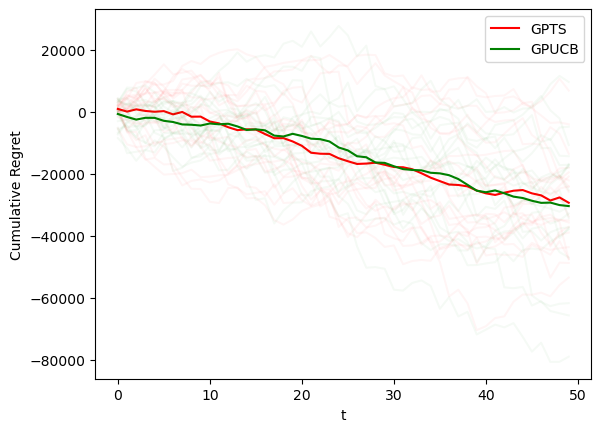

In [7]:
plt.figure(0)
plt.ylabel("Cumulative Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimum_bid[1] - gpts_rewards_per_experiment, axis=0)), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(np.nancumsum(optimum_bid[1] - line, axis=0), "r", alpha=0.3 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.plot(np.cumsum(np.mean(optimum_bid[1] - gpucb_rewards_per_experiment, axis=0)), 'g', label='GPUCB')
for index, line in enumerate(gpucb_rewards_per_experiment):
        plt.plot(np.nancumsum(optimum_bid[1] - line, axis=0), "g", alpha=0.3 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

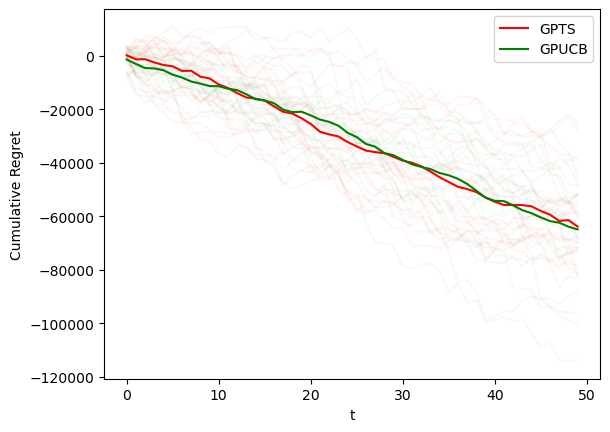

In [8]:
plt.figure(0)
plt.ylabel("Cumulative Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimal_bid - gpts_rewards_per_experiment, axis=0)), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(np.nancumsum(optimal_bid - line, axis=0), "r", alpha=0.3 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.plot(np.cumsum(np.mean(optimal_bid - gpucb_rewards_per_experiment, axis=0)), 'g', label='GPUCB')
for index, line in enumerate(gpucb_rewards_per_experiment):
        plt.plot(np.nancumsum(optimal_bid - line, axis=0), "g", alpha=0.3 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

# Cumulative Reward

The cumulative reward at a given round (in our case day) t is the sum of the rewards received up until and including that day.

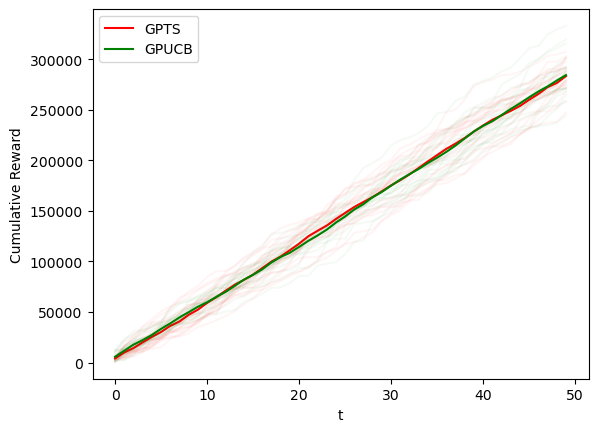

In [9]:
plt.figure(0)
plt.ylabel("Cumulative Reward")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(gpts_rewards_per_experiment, axis=0)), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(np.nancumsum(line, axis=0), "r", alpha=0.3 / np.power(len(gpts_rewards_per_experiment), 2/3))

plt.plot(np.cumsum(np.mean(gpucb_rewards_per_experiment, axis=0)), 'g', label='GPUCB')
for index, line in enumerate(gpucb_rewards_per_experiment):
        plt.plot(np.nancumsum(line, axis=0), "g", alpha=0.3 / np.power(len(gpucb_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

# Istantaneous Regret
Instantaneous regret is a measure of how much better you could have done on a particular day t if you had made the optimal decisions (as determined by your clairvoyant optimization algorithm). It's defined as the difference between the optimal reward and the actual reward received on day t.



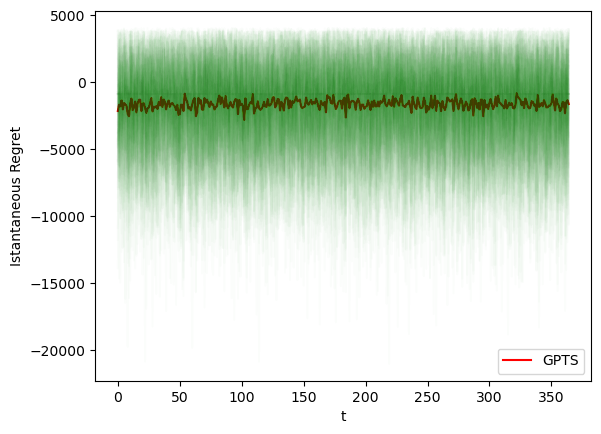

In [9]:
plt.figure(0)
plt.ylabel("Istantaneous Regret")
plt.xlabel("t")
plt.plot(np.mean(optimum_bid[1] - gpts_rewards_per_experiment, axis=0), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(optimum_bid[1] - line, "r",  alpha=0.3 / np.power(len(gpts_rewards_per_experiment) , 2/3))
plt.plot(np.mean(optimum_bid[1] - gpucb_rewards_per_experiment, axis=0), 'g', label='GPUCB')
for index, line in enumerate(gpucb_rewards_per_experiment):
        plt.plot(optimum_bid[1] - line, "g",  alpha=0.3 / np.power(len(gpucb_rewards_per_experiment) , 2/3))
plt.legend()
plt.show()

# Istantaneous Reward
The instantaneous reward at a given round (or day) t would be the reward received on that particular day.

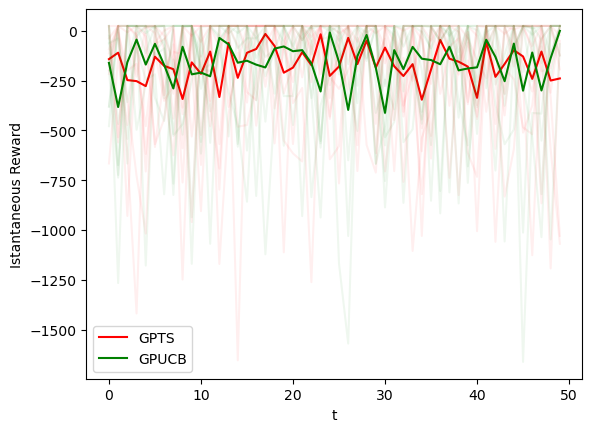

In [23]:
plt.figure(0)
plt.ylabel("Istantaneous Reward")
plt.xlabel("t")
plt.plot(np.mean(gpts_rewards_per_experiment, axis=0), 'r', label='GPTS')
for line in gpts_rewards_per_experiment:
    plt.plot(line, "r", alpha=0.3 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.plot(np.mean(gpucb_rewards_per_experiment, axis=0), 'g', label='GPUCB')
for line in gpucb_rewards_per_experiment:
    plt.plot(line, "g", alpha=0.3 / np.power(len(gpucb_rewards_per_experiment), 2/3))
plt.legend()
plt.show()